# Homework 4 Part 2

This is an individual assignment.

---

# Digits Dataset

In this problem, you will be working with the [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) for dimensionality reduction, followed by a classification task, and performance evaluation based on metrics such as accuracy, ROC curve and confusion matrices.

The digits dataset contains $8\times 8$ grayscale images of handwritten digits (class labels 0, 1, 2, 3, 4, 5, 6, 7, 8 and 9).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy import stats
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE

from time import time
from warnings import filterwarnings

In [2]:
# Loading digits dataset
from sklearn.datasets import load_digits

digits = load_digits(return_X_y=False)
# print(digits.DESCR)

X, t = digits.data, digits.target

X_train, X_test, t_train, t_test = train_test_split(X, t, 
                                                   test_size=0.2,
                                                   stratify=t,
                                                   random_state=1)

X_train.shape, t_train.shape, X_test.shape, t_test.shape

((1437, 64), (1437,), (360, 64), (360,))

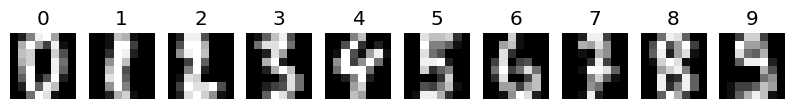

In [3]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[np.where(t_train==i)[0][1],:].reshape((8,8)), cmap='gray')
    plt.title(str(i)); plt.axis('off');

# Problem 1 (20 points)

**Using this train/test partition, answer the following questions:**

1. (6 points) **Apply PCA to reduce dimensionality. How many principal components (PCs) are needed to explain at least 90% of the variance in the data? Justify your answer.**

2. (6 points) **Reconstruct test images using the number of PCs you found earlier. Display a few examples.**

3. (8 points) **Train 2 pipelines with a Logistic Regression classifier (use default parameters and fix ```random_state```) where (1) one with PCA (to explain >=90% variance) and (2) the other without PCA. Report accuracy and confusion matrices in the test set.**

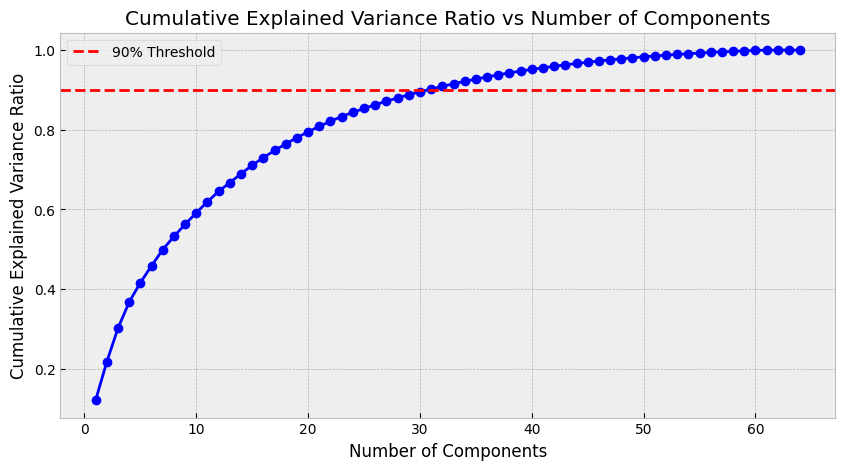

Number of components needed for 90% variance: 31


In [4]:
# Create and fit PCA pipeline
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

pca_pipeline.fit(X_train)

# Get explained variance ratios
explained_var_ratio = pca_pipeline.named_steps['pca'].explained_variance_ratio_

# Create cumulative variance plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var_ratio) + 1), np.cumsum(explained_var_ratio), 'bo-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Components')
plt.grid(True)
plt.legend()
plt.show()

# Calculate number of components for 90% variance
n_components_90 = np.argmax(np.cumsum(explained_var_ratio) >= 0.9) + 1
print(f"Number of components needed for 90% variance: {n_components_90}")

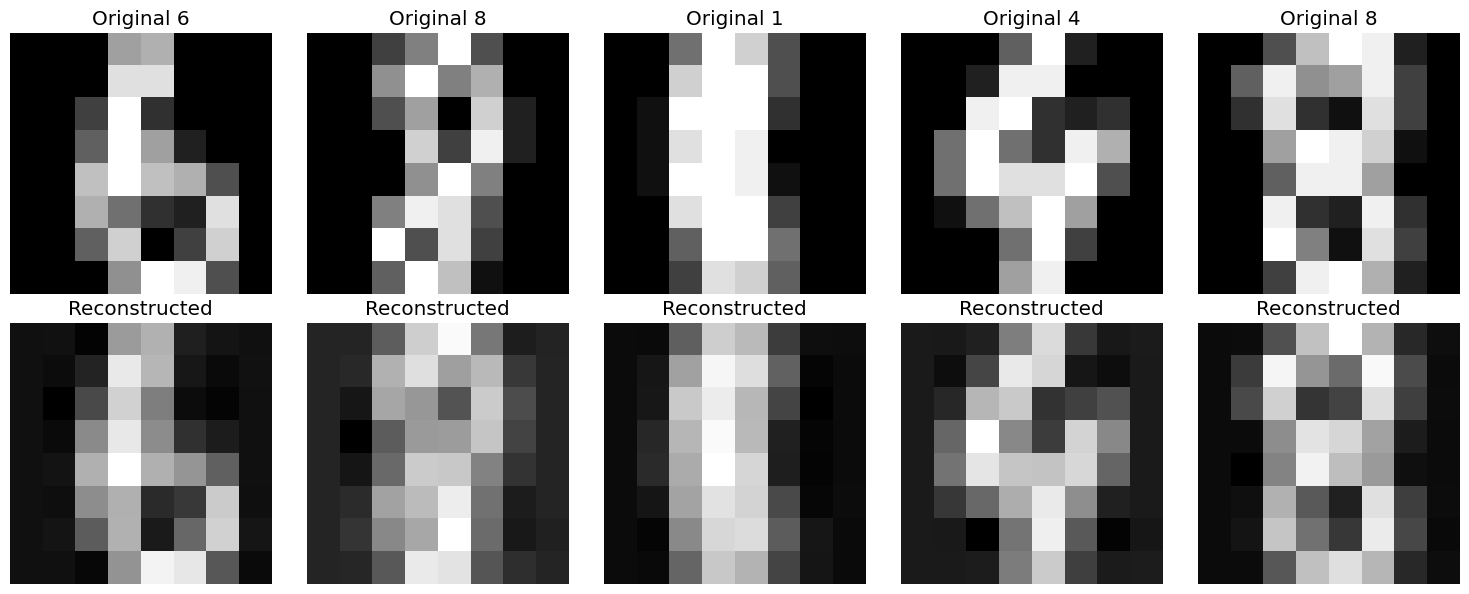

In [5]:
# Create PCA pipeline with n_components_90 components
pca_reconstruction = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components_90))
])

# Fit and transform the data
pca_reconstruction.fit(X_train)
X_test_transformed = pca_reconstruction.transform(X_test)
X_test_reconstructed = pca_reconstruction.inverse_transform(X_test_transformed)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
random_indices = np.random.randint(0, len(X_test), 5)

for i, idx in enumerate(random_indices):
    # Original image
    axes[0, i].imshow(X_test[idx].reshape(8, 8), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {t_test[idx]}')
    
    # Reconstructed image
    axes[1, i].imshow(X_test_reconstructed[idx].reshape(8, 8), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()

In [6]:
# Pipeline 1: With PCA
pca_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components_90)),
    ('lr', LogisticRegression(random_state=1))
])

# Pipeline 2: No PCA & LDA
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=1))
])

# Train and evaluate both pipelines
pipelines = {
    'With PCA': pca_lr_pipeline,
    'Without PCA': lr_pipeline
}

for name, pipeline in pipelines.items():
    # Train
    pipeline.fit(X_train, t_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(t_test, y_pred)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(t_test, y_pred)
    
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)


Results for With PCA:
Accuracy: 0.9694

Confusion Matrix:
[[35  0  0  0  1  0  0  0  0  0]
 [ 0 34  1  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  1  0]
 [ 0  0  0  0 35  0  0  1  0  0]
 [ 0  0  0  0  0 35  1  0  0  1]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 35  1  0]
 [ 1  2  0  0  0  0  0  0 32  0]
 [ 0  0  0  0  0  0  0  0  0 36]]

Results for Without PCA:
Accuracy: 0.9639

Confusion Matrix:
[[36  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  1]
 [ 0  1  0  0 33  0  0  1  0  1]
 [ 0  1  0  0  0 33  1  0  0  2]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  1]
 [ 1  0  0  0  1  1  0  0 32  0]
 [ 0  0  0  0  0  0  0  0  0 36]]


---

# Problem 2 (12 points)

**Using this train/test partition, answer the following questions:**

1. (6 points) **Apply Linear Discriminant Analysis (LDA) to reduce dimensionality. How many components are needed to explain at least 90% of the variance in the data? Justify your answer.**

2. (6 points) **Train a pipeline with a Logistic Regression classifier (use default parameters and fix ```random_state```) with LDA features (as many as there are needed to explain >=90% variance). Report accuracy and confusion matrices in the test set.**

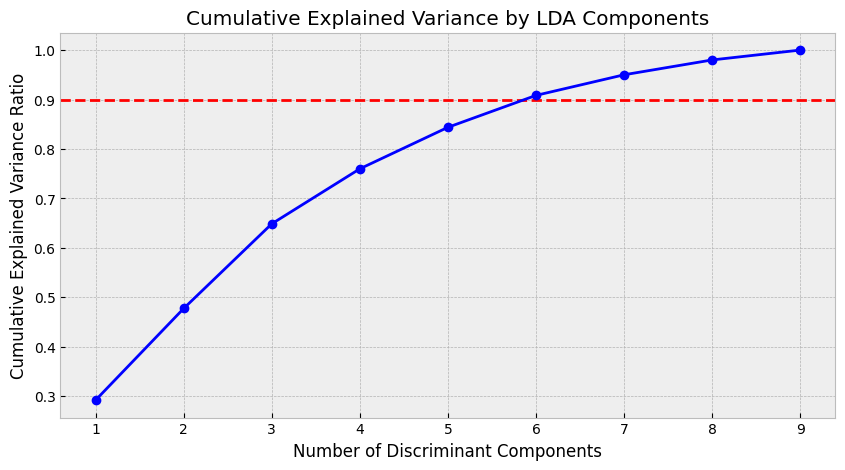

Number of components needed for 90% variance: 6
Actual variance explained with 6 components: 0.9083


In [7]:
# Create and fit LDA pipeline
lda_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA())
])

lda_pipeline.fit(X_train, t_train)

# Get explained variance ratios
explained_var_ratio = lda_pipeline.named_steps['lda'].explained_variance_ratio_

# Create plot
plt.figure(figsize=(10, 5))
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Threshold')
plt.plot(range(1, len(explained_var_ratio) + 1), np.cumsum(explained_var_ratio), 'bo-')
plt.xlabel('Number of Discriminant Components')
plt.ylabel('Cumulative Explained Variance Ratio') 
plt.title('Cumulative Explained Variance by LDA Components')
plt.grid(True)
plt.show()

# Calculate number of components for 90% variance
n_components_90 = np.argmax(np.cumsum(explained_var_ratio) >= 0.9) + 1
print(f"Number of components needed for 90% variance: {n_components_90}")
print(f"Actual variance explained with {n_components_90} components: {np.sum(explained_var_ratio[:n_components_90]):.4f}")

In [11]:
# Create pipeline with LDA and Logistic Regression
lda_lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA(n_components=n_components_90)),
    ('lr', LogisticRegression(random_state=1))
])

# Train pipeline
lda_lr_pipeline.fit(X_train, t_train)

# Make predictions
y_pred = lda_lr_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(t_test, y_pred)
print(f"\nAccuracy with LDA + Logistic Regression: {accuracy:.4f}")

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(t_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

print(f"\nAccuracy without dimensionality reduction: {accuracy_score(t_test, lr_pipeline.predict(X_test)):.4f}")
conf_matrix_lr = confusion_matrix(t_test, lr_pipeline.predict(X_test))
print("\nConfusion Matrix without dimensionality reduction:")
print(conf_matrix_lr)


Accuracy with LDA + Logistic Regression: 0.9306

Confusion Matrix:
[[34  0  0  0  1  0  1  0  0  0]
 [ 0 34  0  0  0  0  0  0  2  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 35  0  1  0  0  1  0]
 [ 0  0  0  0 35  0  0  0  0  1]
 [ 0  0  0  1  0 35  1  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  3  0  0 31  0  2]
 [ 0  6  0  1  0  0  0  1 26  1]
 [ 0  0  0  2  0  0  0  0  0 34]]

Accuracy without dimensionality reduction: 0.9639

Confusion Matrix without dimensionality reduction:
[[36  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  1]
 [ 0  1  0  0 33  0  0  1  0  1]
 [ 0  1  0  0  0 33  1  0  0  2]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  1]
 [ 1  0  0  0  1  1  0  0 32  0]
 [ 0  0  0  0  0  0  0  0  0 36]]


---

# Exercise 3 (10 points)

**Using this train/test partition, answer the following questions:**

1. (7 points) **Train a pipeline with a Multi-layer perceptron classifier (use appropriate hidden layer sizes parameters and fix ```random_state```) and plot the loss curve. Report accuracy and confusion matrices in the test set. [NOTE: use MLPclassifier from sklearn and obtain atleast $95\%$ accuracy]**

2. (3 points) **Visualize images that were misclassified in test. Provide a discussion on your observations and what procedures could you take to improve results on the  MLPclassifier.** 

Iteration 1, loss = 2.35898270
Validation score: 0.291667
Iteration 2, loss = 1.92677529
Validation score: 0.527778
Iteration 3, loss = 1.57748403
Validation score: 0.715278
Iteration 4, loss = 1.26848245
Validation score: 0.791667
Iteration 5, loss = 0.99559423
Validation score: 0.854167
Iteration 6, loss = 0.76886101
Validation score: 0.888889
Iteration 7, loss = 0.59221370
Validation score: 0.895833
Iteration 8, loss = 0.46357900
Validation score: 0.895833
Iteration 9, loss = 0.36811835
Validation score: 0.923611
Iteration 10, loss = 0.29963462
Validation score: 0.930556
Iteration 11, loss = 0.24737919
Validation score: 0.930556
Iteration 12, loss = 0.20711337
Validation score: 0.937500
Iteration 13, loss = 0.17650899
Validation score: 0.944444
Iteration 14, loss = 0.15218945
Validation score: 0.944444
Iteration 15, loss = 0.13302189
Validation score: 0.951389
Iteration 16, loss = 0.11726480
Validation score: 0.944444
Iteration 17, loss = 0.10486573
Validation score: 0.951389
Iterat

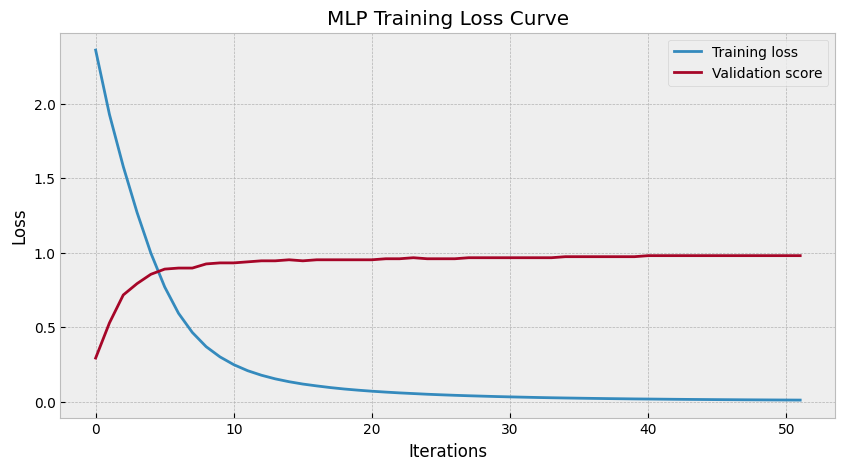

In [9]:
from sklearn.neural_network import MLPClassifier

# Create and train MLP pipeline
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        verbose=True
    ))
])

# Train the model
mlp_pipeline.fit(X_train, t_train)

# Get loss curve
loss_curve = mlp_pipeline.named_steps['mlp'].loss_curve_
val_scores = mlp_pipeline.named_steps['mlp'].validation_scores_

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(loss_curve, label='Training loss')
plt.plot(range(len(loss_curve)-len(val_scores), len(loss_curve)), 
         val_scores, label='Validation score')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()




Accuracy with MLP: 0.9694

Confusion Matrix:
[[36  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  1  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  1  0]
 [ 0  0  0  0 34  0  0  1  0  1]
 [ 0  0  0  0  0 36  1  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  1  0  0 34  1  0]
 [ 0  2  0  0  0  1  0  0 31  1]
 [ 0  0  0  0  0  0  0  0  0 36]]


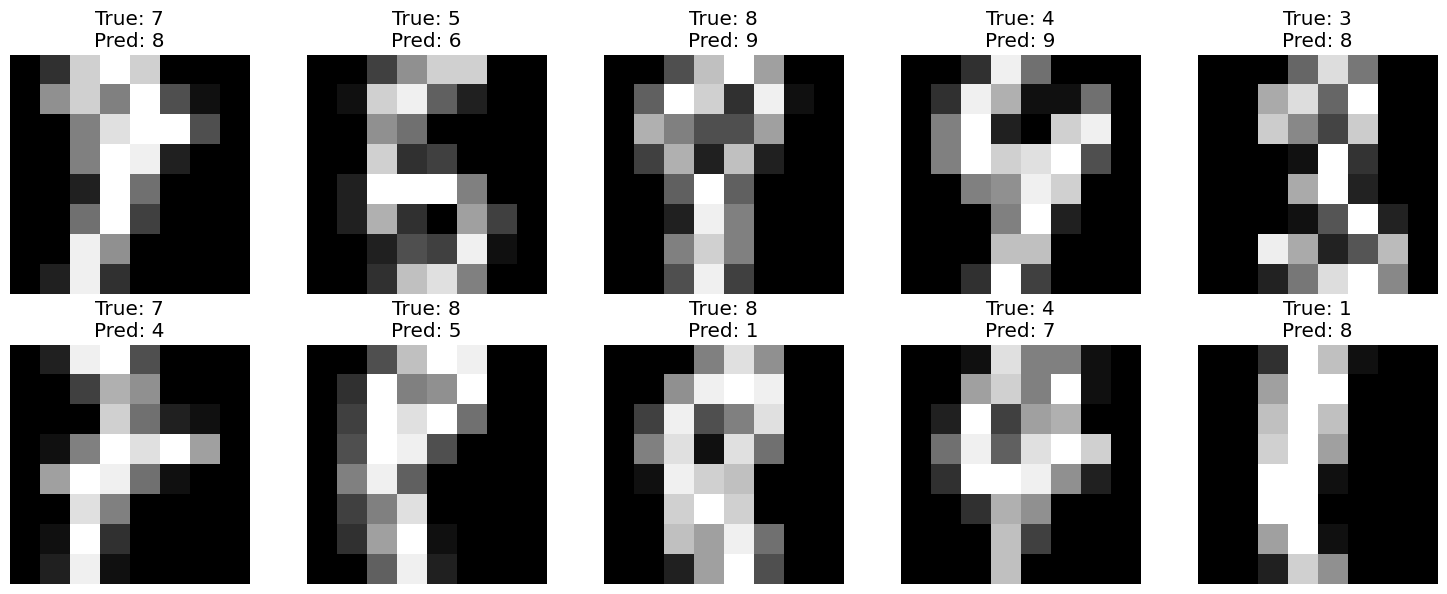


Analysis of misclassifications:
Total misclassified samples: 11

Most common misclassifications:
True: 7, Predicted: 8
True: 5, Predicted: 6
True: 8, Predicted: 9
True: 4, Predicted: 9
True: 3, Predicted: 8
True: 7, Predicted: 4
True: 8, Predicted: 5
True: 8, Predicted: 1
True: 4, Predicted: 7
True: 1, Predicted: 8
True: 8, Predicted: 1


In [10]:
# Make predictions
y_pred = mlp_pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(t_test, y_pred)
print(f"\nAccuracy with MLP: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(t_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Find and display misclassified examples
misclassified = X_test[y_pred != t_test]
true_labels = t_test[y_pred != t_test]
pred_labels = y_pred[y_pred != t_test]

# Plot misclassified images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx in range(min(len(misclassified), 10)):
    axes[idx].imshow(misclassified[idx].reshape(8, 8), cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f'True: {true_labels[idx]}\nPred: {pred_labels[idx]}')

plt.tight_layout()
plt.show()

print("\nAnalysis of misclassifications:")
print(f"Total misclassified samples: {len(misclassified)}")
print("\nMost common misclassifications:")
for i in range(len(true_labels)):
    print(f"True: {true_labels[i]}, Predicted: {pred_labels[i]}")

**Analysis of Misclassified Examples**

The visualization of misclassified examples provides valuable insights into where and why our MLP classifier makes mistakes. Looking at the displayed images, we can observe that many of the misclassifications occur between digits that share similar structural features. For instance, there are cases where the model confuses $3s$ with $5s$, likely due to their similar curved segments and overall shape patterns. Similarly, $4s$ and $9s$ are sometimes mixed up, particularly when the upper portions of these digits exhibit comparable characteristics.

The errors appear to be most prevalent in cases where the handwriting exhibits some form of ambiguity or deviates from standard digit formation. This is particularly evident in examples where the digits contain unusual stylistic variations or where the writing is less distinct. Some misclassified samples show digits with slight distortions or noise, which seems to challenge the model's ability to make correct predictions.

These observations align with common challenges in digit recognition systems, where the model must balance between learning general digit patterns while being robust to natural variations in handwriting styles. Despite these challenges, it's important to note that these misclassifications represent a small fraction of the overall predictions, as evidenced by the model's high accuracy of $96.94\%$. The nature of these errors suggests that the model has successfully learned the primary distinguishing features of digits but occasionally struggles with edge cases where visual similarities between different digits become particularly pronounced.

---

# Problem 4 (3 points)

**Compare performance of all models with and without dimensionality reduction. Which would you select and why?**

| Model | Accuracy | Dimensionality | 
|-------|-----------|----------------|
| Logistic Regression | 0.9639 | 64  |
| PCA + Logistic Regression | 0.9694 | 9 |
| LDA + Logistic Regression | 0.9306 | 9 |
| MLPClassifier | 0.9694 | 64 |

Based on the results above, I would select either PCA + Logistic Regression or MLPClassifier as they both achieve the highest accuracy of 0.9694. However, PCA + Logistic Regression has the advantage of reduced dimensionality (9 vs 64 features), which means:

1. Lower computational complexity and faster training/inference
2. Reduced memory requirements  
3. Less risk of overfitting due to fewer parameters
4. Easier model interpretability

While MLPClassifier matches the accuracy, it requires working with the full 64-dimensional data which increases complexity. Therefore, PCA + Logistic Regression provides the best balance of high accuracy and efficient dimensionality reduction.






---

# On-Time (5 points)

Submit your assignment before the deadline.

---

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.

___